# GPyTorch Regression Tutorial

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function

\begin{align*}
  y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2)
\end{align*}

with 11 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [4]:
import math
import torch
import gpytorch
from gpytorch.kernels import ScaleKernel
from gpytorch.kernels.spectral_autoregressive_flow_kernel import RFNSSpectralNFKernel, RFNSSpectralDeltaKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt

# torch.set_default_dtype(torch.float64)
# %set_env CUDA_VISIBLE_DEVICES=1

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
x_test, y_test, train_x, train_y, test_x, test_y = torch.load('synthetic_spiral')

In [6]:


# n_pts, n_periods = 1000, 1
# theta = torch.linspace(0., (2 * math.pi * n_periods) ** 2, n_pts).sqrt()
# r = theta.unsqueeze(-1) / theta.max()
# X = r * torch.stack((torch.cos(theta), torch.sin(theta)), dim=-1)
# X = X + 1
# X_noisy = X + 0.02 * torch.randn(X.shape)

# plt.scatter(X_noisy[:, 0], X_noisy[:, 1])

# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, deltas, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
# #         self.mean_module = gpytorch.means.LinearMean(1)
#         self.mean_module = gpytorch.means.ConstantMean()
#         base_covar_module = RFNSSpectralDeltaKernel(
#             num_dims=2,
#             num_deltas=1000,
#             nonstationary=False,
#         )
        
#         base_covar_module.lengthscale = 0.4
#         base_covar_module.Z = deltas
        
#         self.covar_module = ScaleKernel(base_covar_module)
#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-10)).cuda()
# likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
# likelihood.noise = 1e-2
# # likelihood.noise_covar.raw_noise.requires_grad_(False)
# model = ExactGPModel(None, None, X_noisy, likelihood)

In [7]:
# model.eval()
# N = 100
# xv, yv = torch.meshgrid([torch.linspace(0, 3, N), torch.linspace(0, 3, N)])
# x_test = torch.cat([xv.reshape(N*N, 1), yv.reshape(N*N, 1)], dim=-1)
# with gpytorch.settings.prior_mode(), torch.no_grad():
#     y_test = model(x_test).rsample()

In [8]:
# plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test.detach().view(N, N))

In [9]:
train_inds = torch.nonzero(~(torch.norm(x_test - torch.tensor([1.5, 1.5]), p=2, dim=-1) <= 0.5)).squeeze()
test_inds = torch.nonzero((torch.norm(x_test - torch.tensor([1.5, 1.5]), p=2, dim=-1) <= 0.5)).squeeze()

# train_x = x_test[train_inds].cuda()
# train_y = y_test[train_inds].cuda()
# test_x = x_test[test_inds].squeeze().cuda()
# test_y = y_test[test_inds].squeeze().cuda()

In [10]:
# import numpy as np

# y_test_blanked = y_test.clone()
# y_test_blanked[test_inds] = np.nan
# plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N))

In [11]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([9152, 2]) torch.Size([9152]) torch.Size([848, 2]) torch.Size([848])


In [12]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.LinearMean(1)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = RFNSSpectralDeltaKernel(
            num_dims=2,
            num_deltas=100,
            nonstationary=False,
        )
#         base_covar_module.Z = X_noisy
#         base_covar_module.raw_Z.requires_grad_(False)
#         other_feat_covar = gpytorch.kernels.MaternKernel(active_dims=range(1, train_x.size(-1)))
        base_covar_module.initialize_from_data(train_x[:, :1], train_y)
#         base_covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=7, ard_num_dims=2)
        base_covar_module.initialize_from_data(train_x.cpu(), train_y.cpu())
    
#         smk.mixture_scales = 30
#         smk.mixture_weights = 0.01
        
        self.covar_module = ScaleKernel(base_covar_module)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-10)).cuda()
likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.01), "noise")
likelihood.noise = 1e-2
# likelihood.noise_covar.raw_noise.requires_grad_(False)
model = ExactGPModel(train_x, train_y, likelihood).cuda()

In [13]:
import pyro

pyro.clear_param_store()

model.train()
likelihood.train()
mll = ExactMarginalLogLikelihood(model.likelihood, model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50])
with gpytorch.settings.max_cholesky_size(0), gpytorch.settings.num_spectral_samples(2000):
    for i in range(1000):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y).mean()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Iteration {i} - loss = {loss:.2f} - noise = {likelihood.noise.mean().item():e}')
        
        scheduler.step()

/opt/conda/conda-bld/pytorch_1579853260681/work/torch/csrc/autograd/generated/python_torch_functions.cpp:4817: UserWarning: This overload of addcmul is deprecated:
addcmul(Tensor input, Number value, Tensor tensor1, Tensor tensor2, Tensor out)
Consider using one of the following signatures instead:
addcmul(Tensor input, Tensor tensor1, Tensor tensor2, Number value, Tensor out)
/opt/conda/conda-bld/pytorch_1579853260681/work/torch/csrc/autograd/generated/python_variable_methods.cpp:1334: UserWarning: This overload of add_ is deprecated:
add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
add_(Tensor other, Number alpha)
/opt/conda/conda-bld/pytorch_1579853260681/work/torch/csrc/autograd/generated/python_variable_methods.cpp:1550: UserWarning: This overload of addcmul_ is deprecated:
addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcmul_(Tensor tensor1, Tensor tensor2, Number value)
/opt

Iteration 0 - loss = 36.42 - noise = 1.104592e-02
Iteration 10 - loss = 13.73 - noise = 2.805955e-02
Iteration 20 - loss = 6.28 - noise = 5.756043e-02
Iteration 30 - loss = 1.79 - noise = 9.105749e-02
Iteration 40 - loss = 2.47 - noise = 1.161548e-01
Iteration 50 - loss = 1.41 - noise = 1.356114e-01
Iteration 60 - loss = 0.84 - noise = 1.370324e-01
Iteration 70 - loss = 0.62 - noise = 1.377881e-01
Iteration 80 - loss = 0.59 - noise = 1.381701e-01
Iteration 90 - loss = 0.46 - noise = 1.383671e-01
Iteration 100 - loss = 0.38 - noise = 1.383976e-01
Iteration 110 - loss = 0.38 - noise = 1.382977e-01
Iteration 120 - loss = 0.32 - noise = 1.381265e-01
Iteration 130 - loss = 0.30 - noise = 1.378884e-01
Iteration 140 - loss = 0.37 - noise = 1.376126e-01
Iteration 150 - loss = 0.36 - noise = 1.373621e-01


KeyboardInterrupt: 

In [14]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.max_cholesky_size(0), gpytorch.settings.fast_pred_var():
    test_x_f = torch.cat([train_x, test_x], dim=-2)
    observed_pred = model.likelihood(model(test_x_f))
    varz = observed_pred.variance

In [15]:
model.eval()
with torch.no_grad(), gpytorch.settings.max_cholesky_size(0), gpytorch.settings.fast_pred_var():
    mu_test = model.likelihood(model(test_x)).mean

## Plot the model fit


In the next cell, we plot the mean and confidence region of the Gaussian process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

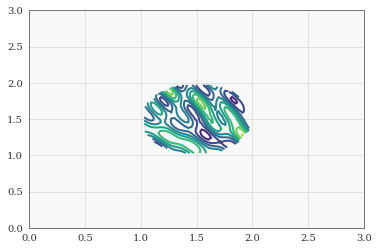

In [26]:
import numpy as np

N = 100

y_test_blanked = y_test.clone()
y_test_blanked[test_inds] = mu_test.cpu().detach()
y_test_blanked[train_inds] = np.nan
plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N))

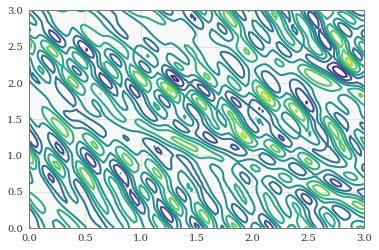

In [17]:
plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test.detach().view(N, N))

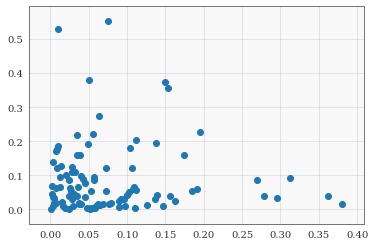

In [18]:
plt.scatter(model.covar_module.base_kernel.Z[:, 0].cpu().detach(), model.covar_module.base_kernel.Z[:, 1].cpu().detach())

/home/jake.gardner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'linewidth'
  if __name__ == '__main__':


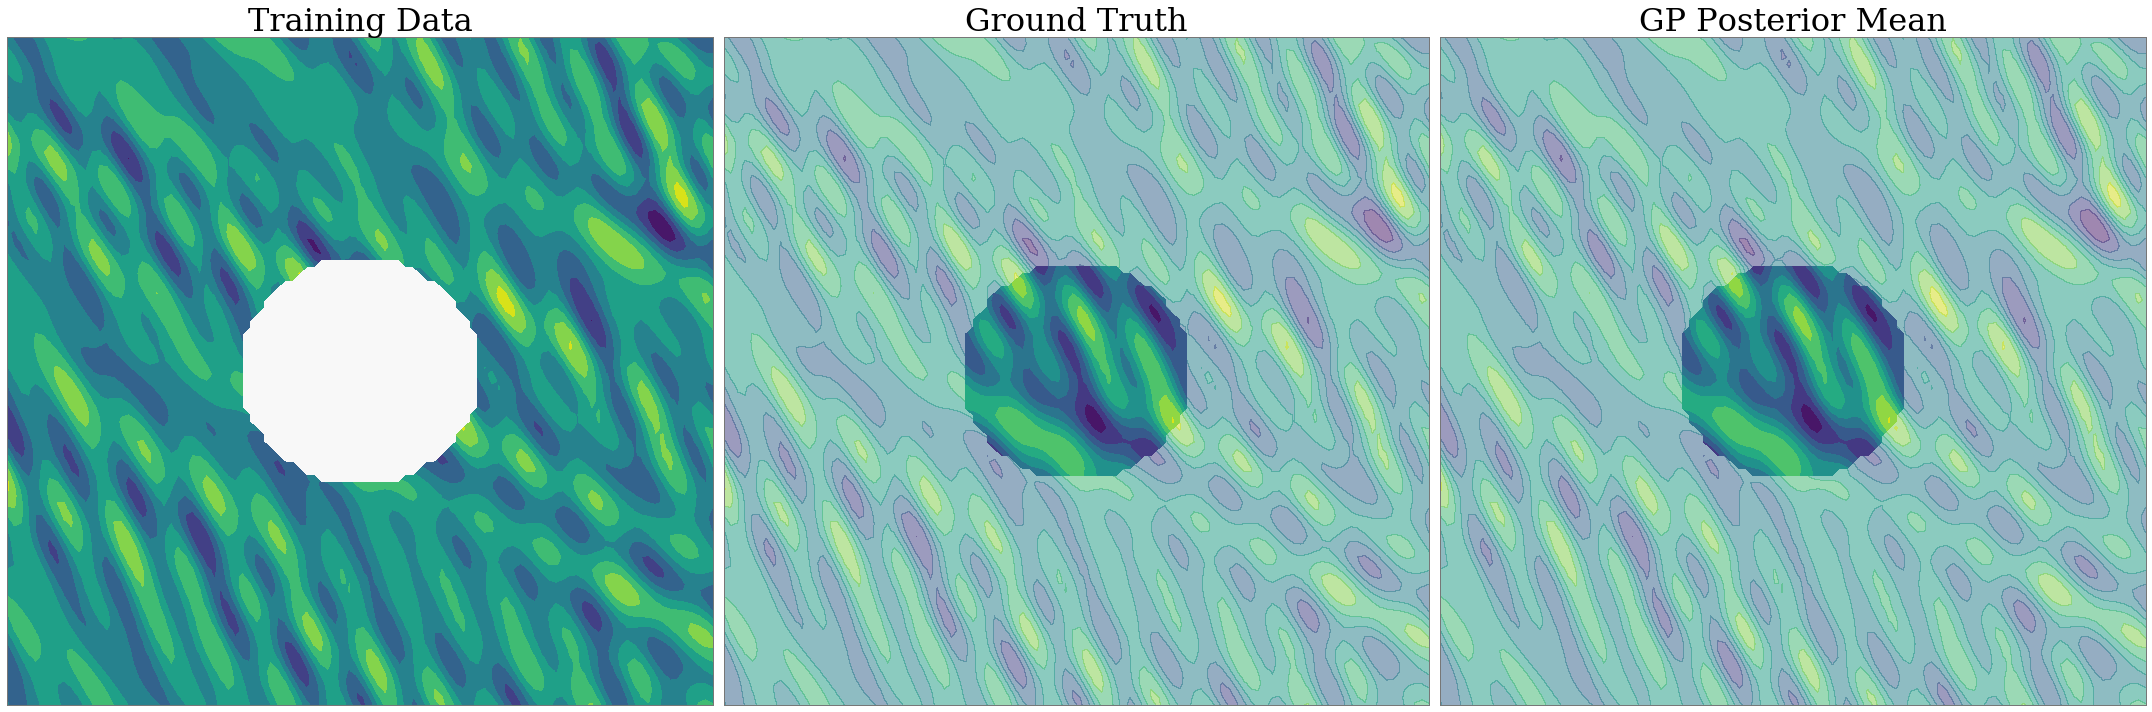

In [39]:
import numpy as np

plt.figure(figsize=(30, 10))

ax = plt.subplot(1, 3, 2)
ax.contourf(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test.detach().view(N, N), alpha=0.5)

y_test_blanked[train_inds] = np.nan
plt.contourf(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N), linewidth=3)

plt.xticks([])
plt.yticks([])
plt.title('Ground Truth', fontsize=32)
ax = plt.subplot(1, 3, 1)
y_test_blanked = y_test.clone()
y_test_blanked[test_inds] = np.nan
ax.contourf(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N))


plt.xticks([])
plt.yticks([])
plt.title('Training Data', fontsize=32)
ax = plt.subplot(1, 3, 3)

y_test_blanked = y_test.clone()
y_test_blanked[test_inds] = mu_test.cpu().detach()
plt.contourf(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N), alpha=0.5)

y_test_blanked[train_inds] = np.nan
plt.contourf(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N))
plt.xticks([])
plt.yticks([])
plt.title('GP Posterior Mean', fontsize=32)

plt.tight_layout()
plt.savefig('synthetic_hard.pdf', bbox_inches=0)

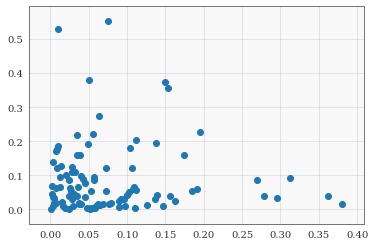

In [41]:
plt.scatter(model.covar_module.base_kernel.Z[:, 0].cpu().detach(), model.covar_module.base_kernel.Z[:, 1].cpu().detach())

In [44]:
from scipy.fftpack import fft
from scipy.integrate import cumtrapz

N = train_x.size(-2)
emp_spect = np.abs(fft(train_y.cpu().detach().numpy())) ** 2 / N
M = math.floor(N / 2)

freq1 = np.arange(M + 1)
freq2 = np.arange(-M + 1, 0)
freq = np.hstack((freq1, freq2)) / N
freq = freq[: M + 1]
emp_spect = emp_spect[: M + 1]

total_area = np.trapz(emp_spect, freq)
spec_cdf = np.hstack((np.zeros(1), cumtrapz(emp_spect, freq)))
spec_cdf = spec_cdf / total_area

a = np.random.rand(1000, 1)
p, q = np.histogram(a, spec_cdf)
bins = np.digitize(a, q)
slopes = (spec_cdf[bins] - spec_cdf[bins - 1]) / (freq[bins] - freq[bins - 1])
intercepts = spec_cdf[bins - 1] - slopes * freq[bins - 1]
inv_spec = (a - intercepts) / slopes

In [45]:
inv_spec.shape

(1000, 1)